We are going to examine an extended example of the nonlinear modelling with a latent force, in particular highlighting the particular knowledge of the form of the differential equation that can be passed to our fitting function. 

The particular example we consider is described by the following set of differential equations
\begin{align*}
    \dot{u} &= v - 1 \\
    \ddot{u} &= -\gamma^2 \left[u + 1/\xi(\theta + \ln(v) \right]
\end{align*}
letting $x = u$ and $y = \dot{u}$ we can consider the related first order system
\begin{align*}
    \dot{x} &= y \\
    \dot{y} &= -\gamma^2 x - -(\gamma^2/\xi) \ln(y+1) - (\gamma^2/\xi) \theta(t)
\end{align*}
the Jacobian of the system is given by
\begin{align}
    J(x(t), y(t) ) &= 
    \begin{bmatrix} 
        0 & 1 \\
        -\gamma^2 & -\frac{\gamma^2}{\xi(y(t)+1) }
    \end{bmatrix}.
\end{align}
By consider a distringuished trajectory of this system, say $x^*(t), y^*(t)$ the eigenvalues of the system along this path are given by

\begin{align*}
    \lambda_1^*(t) &= - \frac{\sqrt{\gamma^2(-4\xi^2y^*(t)^2 - 8\xi^2 y^* (t) - 4\xi^2 + \gamma^2} - \gamma^2}{ 2\xi(y^*(t)+1) } \\
    \lambda_2^*(t) &=  \frac{\sqrt{\gamma^2(-4\xi^2y^*(t)^2 - 8\xi^2 y^* (t) - 4\xi^2 + \gamma^2} - \gamma^2}{ 2\xi(y^*(t)+1) } 
\end{align*}


We are now going to define some user supplied functions allowing us to quickly return the matrix exponential 

$$
\begin{align*}
    \exp\left( \mathbf{J}((t_a + t_b)/2) \right) 
\end{align*}
$$

In [65]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt


xi = 0.3
gamma = 1.

def dXdt_Jac(X, t=0):
    return np.array([[0., 1.], [-gamma**2, -gamma**2/(xi*(X[1] + 1))]])

def eigvals(X):
    X = np.asarray(X, dtype='complex')
    expr = np.sqrt( gamma**2*(-4*xi**2*X[1]**2 - 8*xi**2*X[1] - 4*xi**2 + gamma**2) )
    l1 = (-expr - gamma**2)/(2*xi*(X[1] + 1))
    l2 = (expr - gamma**2)/(2*xi*(X[1]+1))
    return l1, l2

def eigvec(X):
    X = np.asarray(X, dtype='complex')
    expr = np.sqrt(gamma**2*(gamma**2 - 4*xi**2*(X[1]+1)**2))
    v1 = np.array([(expr - gamma**2)/(2*xi*gamma**2*(1+X[1])), 1.])
    v2 = np.array([-(gamma**2+expr)/(2*xi*gamma**2*(1+X[1])), 1.])
    return v1, v2

def eigenDecomp(X):
    l = eigvals(X)
    v1, v2 = eigvec(X)
    V = np.column_stack((v1, v2))
    Vinv = np.linalg.inv(V)
    return l, V, Vinv

def expmJ(X, tb, t):
    ll, V, Vinv = eigenDecomp(X)
    D = np.diag([np.exp(l*(tb-t)) for l in ll])
    return np.real(np.dot(V, np.dot(D, Vinv)))


The point being we can now introduced the system linearised along this trajectory given by
\begin{align*}
    \begin{bmatrix}
        \dot{\delta}_x \\ \dot{\delta}_y 
    \end{bmatrix} = 
    \begin{bmatrix}
        0 & 1 \\
        -\gamma^2 & -\frac{\gamma^2}{\xi(y^*(t)+1) }
    \end{bmatrix}\begin{bmatrix} \delta_x \\ \delta_y \end{bmatrix} + \begin{bmatrix} 0 \\ \delta_f(t) \end{bmatrix}
\end{align*}

We extend the system we are interested in with a known functional form for the latent state $\theta(t)$ described by
\begin{align*}
    \dot{u} &= v - 1 \\
    \dot{v} &= -\gamma^2\left[ \right] \\
    \dot{\theta} &= -v(\theta + (1+\epsilon)\ln(v) )
\end{align*}

Below we set up the true governing dynamics and take some noisy observations:

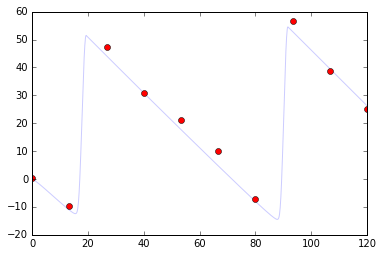

In [96]:
eps = 1.9

def dYdt(Y, t=0):
    udot = Y[1] - 1
    vdot = -gamma**2*(Y[0] + (1/xi)*(Y[2] + np.log(Y[1])))
    fdot = -Y[1]*(Y[2]+(1+eps)*np.log(Y[1]))
    return np.array([udot, vdot, fdot])

initCond = [0., 0.5, 0.8]
tt = np.linspace(0., 120, 1000)

obsInd = np.linspace(0, tt.size-1, 10, dtype=np.intp)
evalt = tt[obsInd]

sol = odeint(dYdt, initCond, tt)
evalU = sol[obsInd,0] + np.random.normal(size=evalt.size, scale=3.)


fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(tt, sol[:,0], 'b-', alpha=0.2)
ax.plot(evalt, evalU, 'ro')
plt.show()


### Standard Gaussian Process Regression
At this point, having realised some observed data, it may be instructive to consider the result of trying to fit a conventional Gaussian process model to the displacement data

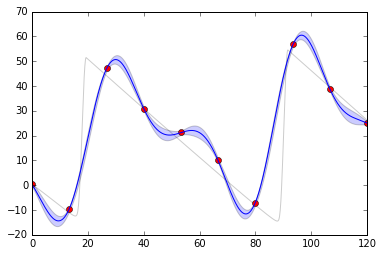

In [119]:
c = 20.
l = 10.
noiseTerm = .1
def kernel(s,t):
    return c*np.exp(-0.5*(s-t)**2/l**2)

C = np.array([[kernel(s,t) for t in evalt] for s in evalt]) + noiseTerm*np.diag(np.ones(evalt.size))
L = np.linalg.cholesky(C)
Cinva = np.linalg.solve(L.T, np.linalg.solve(L, evalU))

def pred(t):
    k = [kernel(t, s) for s in evalt]
    mean = np.dot(k, Cinva)

    v = kernel(t,t) + noiseTerm
    k = [kernel(t, s) for s in evalt]
    var = v - np.dot(k, np.linalg.solve(L.T, np.linalg.solve(L, k)))

    return mean, var
    
fig2 = plt.figure()
ax = fig2.add_subplot(111)
ax.plot(tt, sol[:,0], 'k-', alpha=0.2)
ax.plot(evalt, evalU, 'ro')

MV = np.array([pred(t) for t in tt])
sd = np.sqrt(MV[:,1])

ax.plot(tt, MV[:,0])
ax.fill_between(tt, MV[:,0] + 2*sd, MV[:,0] - 2*sd, facecolor='blue', alpha=0.2)

plt.show()


Clearly the choice of a squared exponential kernel does a poor job of recovering the true evolution of the displacement, now it may be possible to rectify this by choosing a more appropriate kernel, but for the practitioner interested in physical hypothesis regarding the underlying dynamics there is a more important reason for considering the more complicated models and that is to uncover the latent processes governing these dynamics.

In [123]:
print 22*(1.1)**10

57.0623341222
